<h1 style="text-align: center;">Statistics for Business - Turnover Prediction</h1>

# Preparation

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns

# modelling
import statsmodels.formula.api as smf
from scipy.special import expit, logit
from sklearn.preprocessing import LabelEncoder


sns.set_palette('muted')

## Function

In [3]:
def print_coef_std_err(results):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from 
    :return df: <pandas DataFrame> 
    """
    coef = results.params
    std_err = results.bse
    
    df = pd.DataFrame(data = np.transpose([coef, std_err]), 
                      index = coef.index, 
                      columns=["coef","std err"])
    return df

## Data loading

In [4]:
# load the csv file

df = pd.read_csv('turnover.csv')
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


In [5]:
# rename sales to department

df = df.rename(columns={
    'sales': 'department'})

In [6]:
# bring left column to the first column

front = df['left']
df.drop(labels=['left'], axis=1,inplace = True)
df.insert(0, 'left', front)
df

,left,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary
0,1,0.38,0.53,2,157,3,0,0,sales,low
1,1,0.80,0.86,5,262,6,0,0,sales,medium
2,1,0.11,0.88,7,272,4,0,0,sales,medium
3,1,0.72,0.87,5,223,5,0,0,sales,low
4,1,0.37,0.52,2,159,3,0,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,1,0.40,0.57,2,151,3,0,0,support,low
14995,1,0.37,0.48,2,160,3,0,0,support,low
14996,1,0.37,0.53,2,143,3,0,0,support,low
14997,1,0.11,0.96,6,280,4,0,0,support,low


In [7]:
# data types each fetaures

df.dtypes

left                       int64
satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
promotion_last_5years      int64
department                object
salary                    object
dtype: object

In [8]:
# null check

df.isnull().any()

left                     False
satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
Work_accident            False
promotion_last_5years    False
department               False
salary                   False
dtype: bool

## Analysis

In [9]:
# descriptive statistics

df.describe().T

,count,mean,std,min,25%,50%,75%,max
left,14999.0,0.238083,0.425924,0.00,0.00,0.00,0.00,1.0
satisfaction_level,14999.0,0.612834,0.248631,0.09,0.44,0.64,0.82,1.0
last_evaluation,14999.0,0.716102,0.171169,0.36,0.56,0.72,0.87,1.0
number_project,14999.0,3.803054,1.232592,2.00,3.00,4.00,5.00,7.0
average_montly_hours,14999.0,201.050337,49.943099,96.00,156.00,200.00,245.00,310.0
time_spend_company,14999.0,3.498233,1.460136,2.00,3.00,3.00,4.00,10.0
Work_accident,14999.0,0.144610,0.351719,0.00,0.00,0.00,0.00,1.0
promotion_last_5years,14999.0,0.021268,0.144281,0.00,0.00,0.00,0.00,1.0


In [10]:
# left base

left_rate = df.left.value_counts() / len(df)
left_rate

0    0.761917
1    0.238083
Name: left, dtype: float64

As a baseline; there are 76% of employees stayed and 24% of employees left the company.

In [11]:
# left first sight

left_summary = df.groupby('left')
left_summary.mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
left,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


<Axes: >

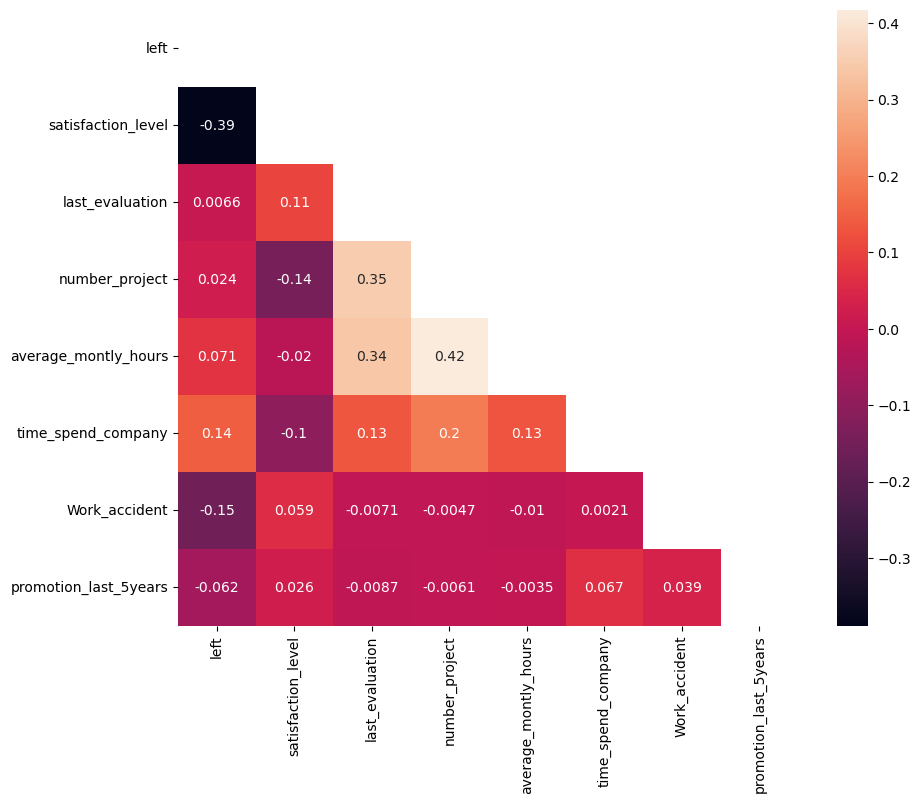

In [12]:
# correlation heatmap

plt.figure(figsize=(10,8))
corr = df.corr()
mask = np.triu(np.ones_like(df.corr()))
sns.heatmap(corr, annot=True, mask=mask)

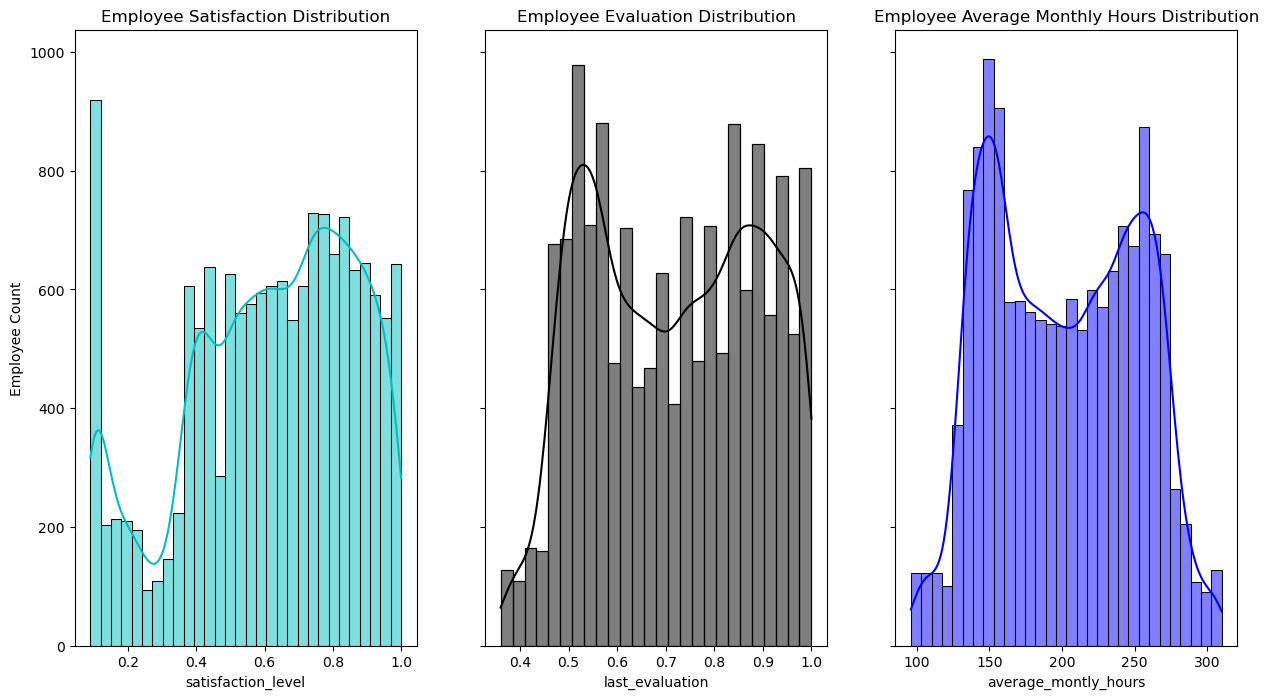

In [14]:
# Set up the matplotlib figure
fig, ax = plt.subplots(ncols=3, figsize=(15, 8), sharey=True)

# Graph Employee Satisfaction
sns.histplot(df.satisfaction_level, color='c', kde=True, ax=ax[0]).set_title('Employee Satisfaction Distribution')
ax[0].set_ylabel('Employee Count')

# Graph Employee Evaluation
sns.histplot(df.last_evaluation, color='k', kde=True, ax=ax[1]).set_title('Employee Evaluation Distribution')

# Graph Employee Average Monthly Hours
sns.histplot(df.average_montly_hours, color='b', kde=True, ax=ax[2]).set_title('Employee Average Monthly Hours Distribution')

plt.show()

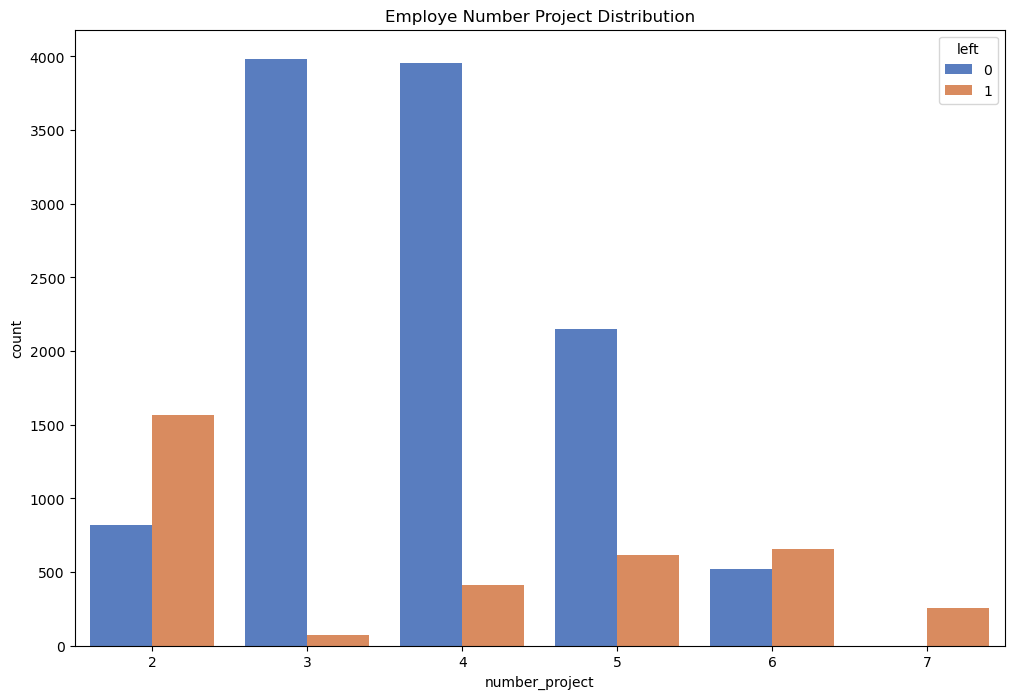

In [15]:
# number of project worked vs left

fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(x='number_project', hue='left', data=df).set_title('Employe Number Project Distribution')
plt.show()

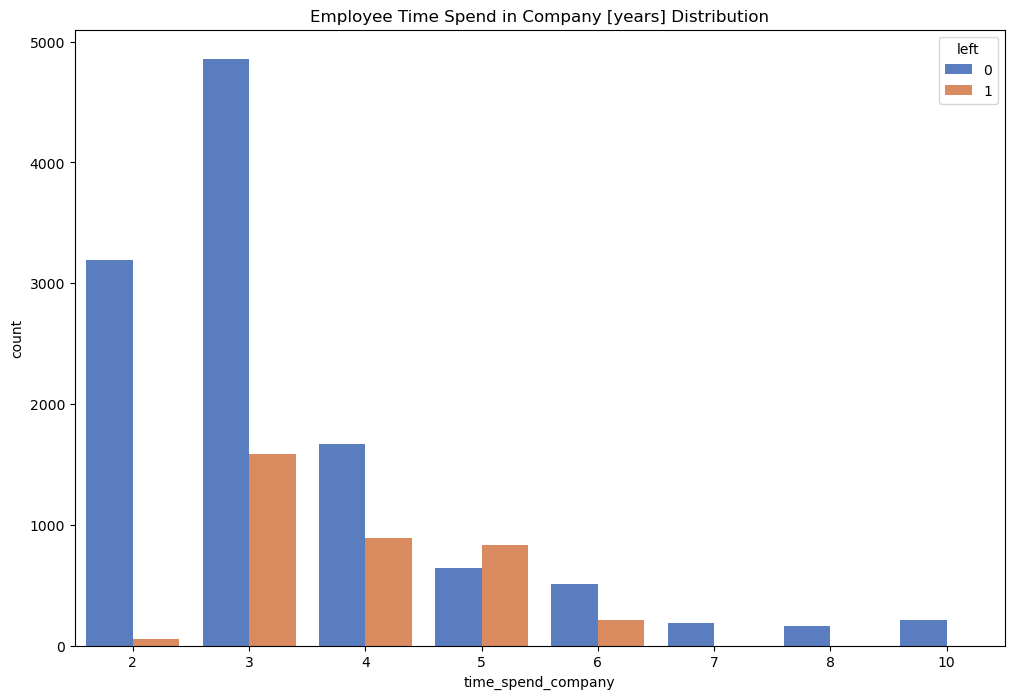

In [16]:
# time spend at company vs left

fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(x='time_spend_company', hue='left', data=df).set_title('Employee Time Spend in Company [years] Distribution')
plt.show()

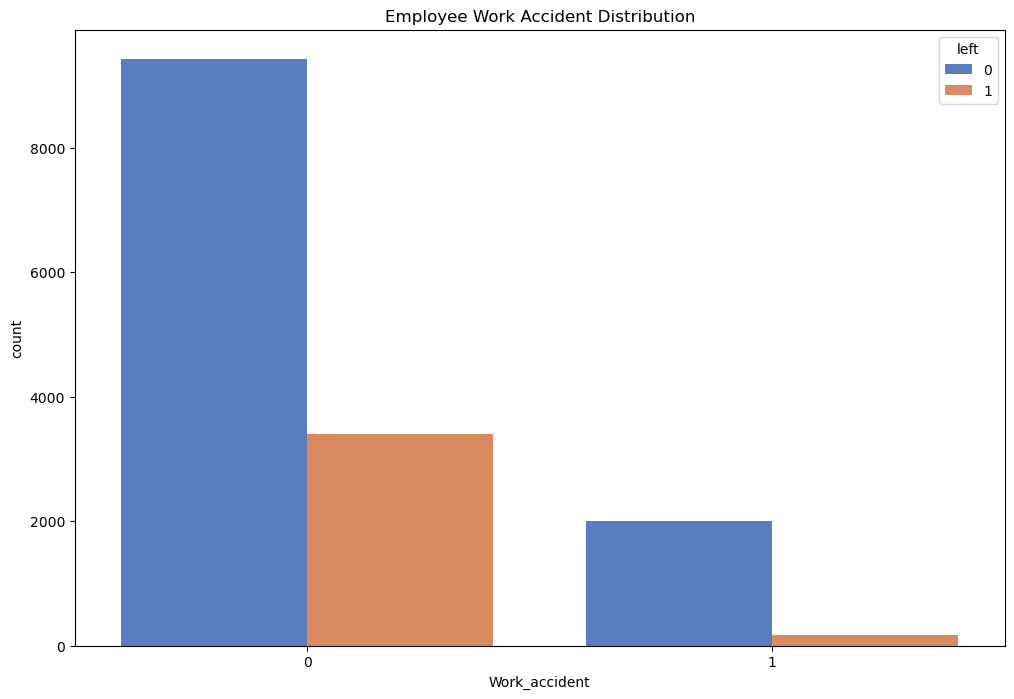

In [17]:
# work accident vs left

fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(x='Work_accident', hue='left', data=df).set_title('Employee Work Accident Distribution')
plt.show()

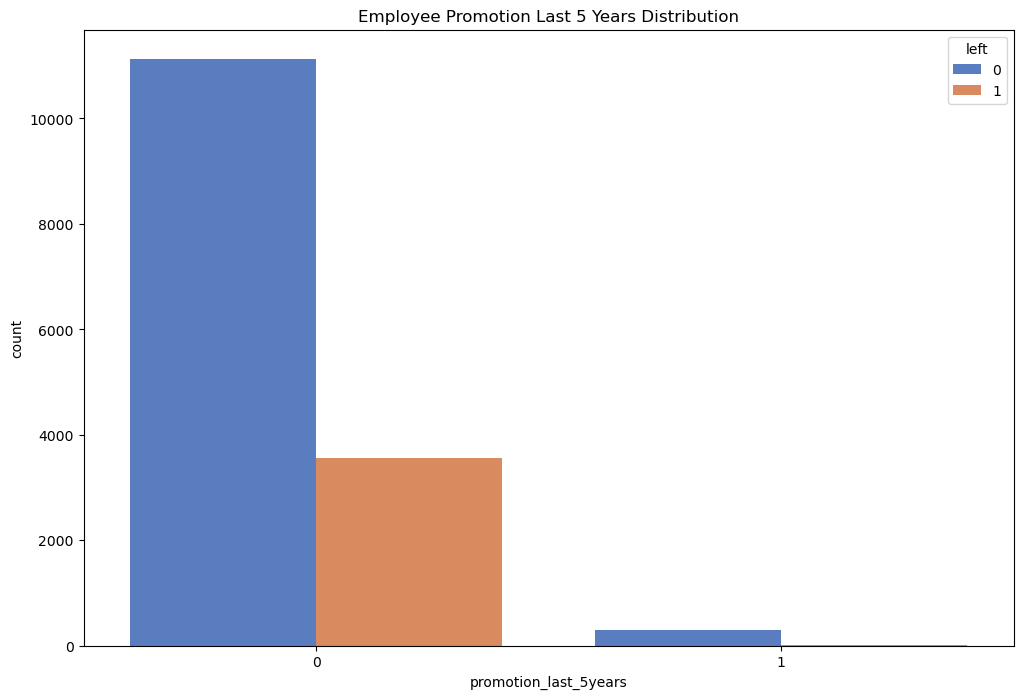

In [18]:
# last 5 years promotion vs left

fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(x='promotion_last_5years', hue='left', data=df).set_title('Employee Promotion Last 5 Years Distribution')
plt.show()

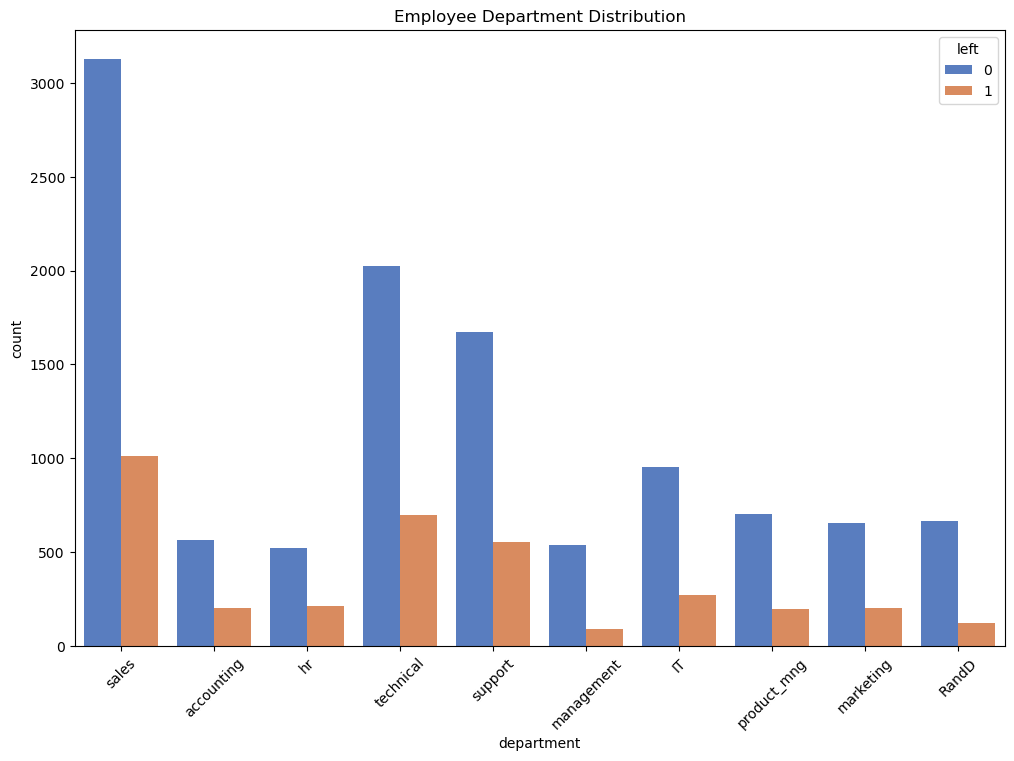

In [19]:
# department vs left

fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(x='department', hue='left', data=df).set_title('Employee Department Distribution')
plt.xticks(rotation=45)
plt.show()

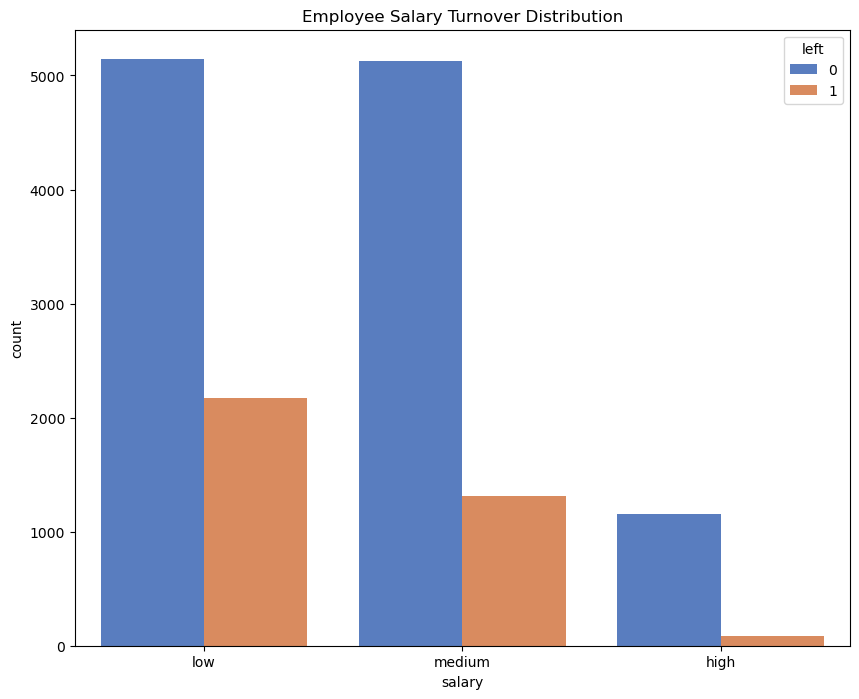

In [20]:
# salary vs left

fig, ax = plt.subplots(figsize=(10, 8))
sns.countplot(x="salary", hue='left', data=df).set_title('Employee Salary Turnover Distribution')
plt.show()

In [21]:
df

,left,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary
0,1,0.38,0.53,2,157,3,0,0,sales,low
1,1,0.80,0.86,5,262,6,0,0,sales,medium
2,1,0.11,0.88,7,272,4,0,0,sales,medium
3,1,0.72,0.87,5,223,5,0,0,sales,low
4,1,0.37,0.52,2,159,3,0,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,1,0.40,0.57,2,151,3,0,0,support,low
14995,1,0.37,0.48,2,160,3,0,0,support,low
14996,1,0.37,0.53,2,143,3,0,0,support,low
14997,1,0.11,0.96,6,280,4,0,0,support,low


## Fit logistic regression

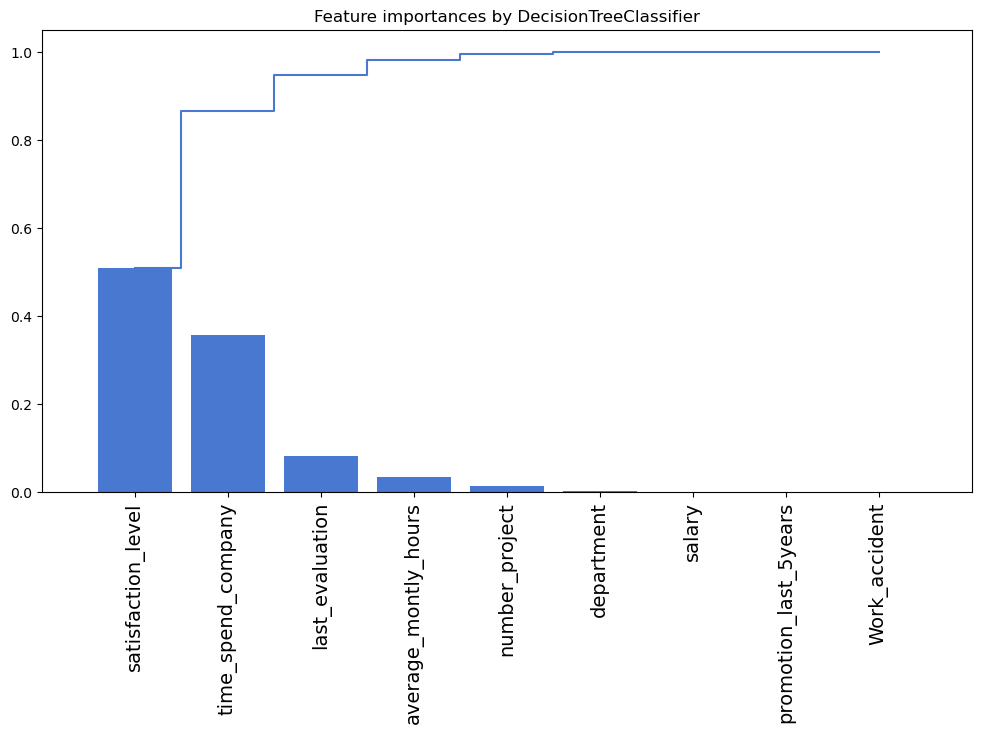

In [23]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

df = df.rename(columns={
    'left': 'turnover'})

# Convert into categorical variables
df["department"] = df["department"].astype('category').cat.codes
df["salary"] = df["salary"].astype('category').cat.codes

target_name = 'turnover'
X = df.drop('turnover', axis=1)


y=df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=123, stratify=y)

dtree = tree.DecisionTreeClassifier(
    class_weight="balanced",
    min_weight_fraction_leaf=0.01
    )
dtree = dtree.fit(X_train,y_train)

importances = dtree.feature_importances_
feat_names = df.drop(['turnover'],axis=1).columns


indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])

plt.show()

In [26]:
df['int'] = 1
indep_var = ['satisfaction_level', 'time_spend_company', 'last_evaluation', 'int', 'turnover']
df = df[indep_var]

# Create train and test splits
target_name = 'turnover'
X = df.drop('turnover', axis=1)

y=df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=123, stratify=y)

X_train.head()

,satisfaction_level,time_spend_company,last_evaluation,int
9003,0.59,3,1.00,1
5697,0.81,2,0.98,1
10691,1.00,2,0.93,1
1884,0.87,5,0.91,1
13572,0.87,3,0.48,1


In [34]:
# Create Logit model object
logit_model = smf.logit('turnover ~  satisfaction_level + time_spend_company + last_evaluation', df)

# Fit the model
model_turnover = logit_model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_turnover_coef = print_coef_std_err(model_turnover)

Optimization terminated successfully.
         Current function value: 0.467831
         Iterations 6


In [35]:
results_turnover_coef

,coef,std err
Intercept,0.110921,0.104070
satisfaction_level,-3.738493,0.087540
time_spend_company,0.170252,0.013806
last_evaluation,0.284814,0.122044


In [36]:
# create function to compute coefficients

def turnover_percent(satisfaction, evaluation, yearsAtCompany):
    y = ((0.1)-3.7*satisfaction + 0.28*evaluation + 0.17*yearsAtCompany)
    p = ((np.exp(y) / (1+np.exp(y))) * 100).round(2)
    return print(f'Score to left company: {p}%')

In [37]:
turnover_percent(0.37, 0.48, 3)

Score to left company: 34.87%


In [31]:
df

,satisfaction_level,time_spend_company,last_evaluation,int,turnover
0,0.38,3,0.53,1,1
1,0.80,6,0.86,1,1
2,0.11,4,0.88,1,1
3,0.72,5,0.87,1,1
4,0.37,3,0.52,1,1
...,...,...,...,...,...
14994,0.40,3,0.57,1,1
14995,0.37,3,0.48,1,1
14996,0.37,3,0.53,1,1
14997,0.11,4,0.96,1,1
